We are trying to see if there is a correlation between working on neurotech & my physio activity (oura)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np # for numeric calculation
import matplotlib.pyplot as plt # for data visualization

# this is grouped activity watch data
aw_data = pd.read_csv("../data/aw_data_grouped.csv")
pd.set_option('display.max_colwidth', None)
pd.set_option('max_columns', None)

# filter for neurotech events
import re

def is_neuro(text):
    if re.search('(neuro)|(eeg)|(brain)',text) != None:
        return 1
    return 0

aw_data["is_neurotech"] = aw_data["event_classification"].apply(lambda x: is_neuro(x))

# set duration second to zero if it is not neuro
aw_data["duration_seconds"] = aw_data[['is_neurotech','duration_seconds']].apply(lambda x: x['duration_seconds'] if x['is_neurotech'] == 1 else 0, axis=1)

# get data summarized by day
aw_data_neuro_grouped = aw_data.groupby(["summary_day"], as_index=False)
aw_data_neuro_grouped = aw_data_neuro_grouped.agg({
                            'is_neurotech': 'sum',
                            'duration_seconds': 'sum'
                        })
aw_data_neuro_grouped.rename(columns = {'is_neurotech':'activity_frequency', 'duration_seconds':'activity_duration'}, inplace = True)
aw_data_neuro_grouped

,summary_day,activity_frequency,activity_duration
0,2021-02-27,4,60.327
1,2021-02-28,3,2775.748
2,2021-03-01,4,3952.435
3,2021-03-02,3,416.324
4,2021-03-03,1,15.462
...,...,...,...
146,2021-07-31,6,1168.016
147,2021-08-01,5,178.850
148,2021-08-02,1,0.000
149,2021-08-03,1,12.104


In [2]:
oura_data = pd.read_csv("../data/oura_cleaned.csv")

print(oura_data.columns)

# sleeptime should be converted into a numeric representation 
# - (unixTimestamp), rest_minutes
# heartrate - hr_average_act_1, hr_lowest_act_1, score_hrv_balance, score_resting_hr, hr_5min, hr_average_res_1, hr_lowest_res_1
# activity - score_activity_balance, score_hrv_balance, score_resting_hr, score_sleep_balance, score_recovery_index

Index(['Unnamed: 0', 'average_met', 'cal_active', 'cal_total_kcal',
       'class_5min', 'daily_movement', 'day_end', 'day_start', 'high_minutes',
       'inactive_minutes', 'inactivity_alerts', 'low_minutes',
       'medium_minutes', 'met_1min', 'met_min_high', 'met_min_inactive',
       'met_min_low', 'met_min_medium', 'non_wear_minutes', 'rest_minutes',
       'rest_mode_state_act_1', 'score_act_1', 'score_meet_daily_targets',
       'score_move_every_hour', 'score_recovery_time', 'score_stay_active',
       'score_training_frequency', 'score_training_volume', 'steps',
       'summary_date_act', 'target_calories', 'target_km', 'target_miles',
       'timezone_act', 'to_target_km', 'to_target_miles', 'total_act_1',
       'bedtime_end_act_1', 'bedtime_start_act_1', 'breath_average_act_1',
       'duration_act_1', 'period_id_act_1', 'summary_date_res', 'timezone_res',
       'hr_average_act_1', 'hr_lowest_act_1', 'rmssd_act_1', 'period_id_res_1',
       'rest_mode_state_res_1', 'score

In [3]:
spotify_data = pd.read_csv("../data/spotify_data_summary.csv")

print(spotify_data.columns)

Index(['summary_day', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')


In [11]:
# create combined dataset for correlation
# data column here is - summary_day
aw_for_correlation = aw_data_neuro_grouped.iloc[:-1]
aw_for_correlation.set_index('summary_day')

# date column here is - summary_date_act (could be different we have like 4 candidates in this dataset)
oura_data_for_correlation = oura_data.iloc[38:, ]
oura_data_for_correlation.rename(columns = {'summary_date_act':'summary_day'}, inplace = True)
oura_data_for_correlation.set_index("summary_day")

# include spotify data

combined_dataset = aw_for_correlation.merge(oura_data_for_correlation, on="summary_day", how="left")
combined_dataset = combined_dataset.merge(spotify_data, on="summary_day", how="left")

combined_dataset_2 = combined_dataset[["activity_frequency", "activity_duration", "bedtime_end_delta", "deep_seconds", 
                                        "hr_average_act_1", "hr_lowest_act_1", "score_hrv_balance", "score_resting_hr",
                                       "hr_average_res_1", "hr_lowest_res_1","danceability", "energy", "key", "loudness", "mode",
                                       "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]]

# heartrate - hr_average_act_1, hr_lowest_act_1, score_hrv_balance, score_resting_hr, hr_5min, hr_average_res_1, hr_lowest_res_1
# activity - score_activity_balance, score_hrv_balance, score_resting_hr, score_sleep_balance, score_recovery_index

# combined_dataset_2 = combined_dataset_2.apply (pd.to_numeric, errors='coerce')
# combined_dataset_2 = combined_dataset_2.dropna()



combined_dataset_2

c:\users\oreog\miniconda3\envs\fusion\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,activity_frequency,activity_duration,bedtime_end_delta,deep_seconds,hr_average_act_1,hr_lowest_act_1,score_hrv_balance,score_resting_hr,hr_average_res_1,hr_lowest_res_1,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4,60.327,18139.0,7860.0,81.9,78.0,92.0,100.0,60.09,55.0,0.656500,0.241537,5.500000,-14.316375,0.625000,0.134763,0.755250,0.842375,0.145000,0.264950,102.048000
1,3,2775.748,27037.0,9840.0,71.0,71.0,91.0,78.0,56.70,53.0,0.751727,0.657000,5.454545,-8.298636,0.454545,0.143927,0.553182,0.152829,0.128364,0.725727,145.055545
2,4,3952.435,19801.0,7380.0,72.5,72.0,88.0,46.0,53.67,50.0,0.594381,0.636143,6.333333,-8.446429,0.476190,0.082286,0.359500,0.063861,0.124848,0.466495,116.666381
3,3,416.324,19923.0,8040.0,66.0,66.0,88.0,95.0,64.29,56.0,0.669116,0.531116,5.069767,-9.186372,0.534884,0.122549,0.430495,0.266099,0.160323,0.439956,116.139698
4,1,15.462,17403.0,9180.0,59.0,58.0,86.0,95.0,51.08,49.0,0.667680,0.480840,3.160000,-8.740440,0.840000,0.225980,0.442204,0.047894,0.166396,0.510000,106.513520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3,3204.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,6,1168.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,5,178.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,1,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,activity_frequency,activity_duration,bedtime_end_delta,deep_seconds,hr_average_act_1,hr_lowest_act_1,score_hrv_balance,score_resting_hr,hr_average_res_1,hr_lowest_res_1,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4,60.327,18139.0,7860.0,81.9,78.0,92.0,100.0,60.09,55.0,0.656500,0.241537,5.500000,-14.316375,0.625000,0.134763,0.755250,0.842375,0.145000,0.264950,102.048000
1,3,2775.748,27037.0,9840.0,71.0,71.0,91.0,78.0,56.70,53.0,0.751727,0.657000,5.454545,-8.298636,0.454545,0.143927,0.553182,0.152829,0.128364,0.725727,145.055545
2,4,3952.435,19801.0,7380.0,72.5,72.0,88.0,46.0,53.67,50.0,0.594381,0.636143,6.333333,-8.446429,0.476190,0.082286,0.359500,0.063861,0.124848,0.466495,116.666381
3,3,416.324,19923.0,8040.0,66.0,66.0,88.0,95.0,64.29,56.0,0.669116,0.531116,5.069767,-9.186372,0.534884,0.122549,0.430495,0.266099,0.160323,0.439956,116.139698
4,1,15.462,17403.0,9180.0,59.0,58.0,86.0,95.0,51.08,49.0,0.667680,0.480840,3.160000,-8.740440,0.840000,0.225980,0.442204,0.047894,0.166396,0.510000,106.513520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3,3204.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,6,1168.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,5,178.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,1,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#individual two column correlations

import numpy as np

two_features_dataset = combined_dataset_2[["activity_duration", "bedtime_end_delta"]].dropna()

activity_duration = two_features_dataset["activity_duration"].to_numpy()


bedtime_end_delta = two_features_dataset['bedtime_end_delta'].to_numpy()

print(activity_duration)
print(bedtime_end_delta)

[6.0327000e+01 2.7757480e+03 3.9524350e+03 4.1632400e+02 1.5462000e+01
 0.0000000e+00 0.0000000e+00 1.0251400e+02 5.6062000e+01 9.0391000e+01
 3.0037490e+03 1.9639400e+02 1.3646320e+03 4.2152160e+03 1.7749315e+04
 1.1845346e+04 9.3349330e+03 5.1431800e+02 4.9938860e+03 1.0453470e+03
 3.5565510e+03 1.4157031e+04 1.7281000e+03 5.2100870e+03 1.1695900e+02
 1.1306170e+03 0.0000000e+00 0.0000000e+00 4.0346000e+01 2.5368000e+01
 3.1351400e+03 6.3943200e+02 1.3321000e+02 0.0000000e+00 4.6782490e+03
 1.2941100e+02]
[18139. 27037. 19801. 19923. 17403. 26942. 28379. 20401. 21904. 22502.
 23821. 25439. 22810. 21902. 35102. 30542. 22980.  7743. 22081. 22471.
 21214. 20552. 23491. 15990. 23372. 30692. 25231. 19894. 19653. 23730.
 19773. 19985. 26131. 22144. 26851. 14911.]


activity_duration: mean=2678.136 stdv=4214.565
bedtime_end_delta: mean=22526.000 stdv=4816.578


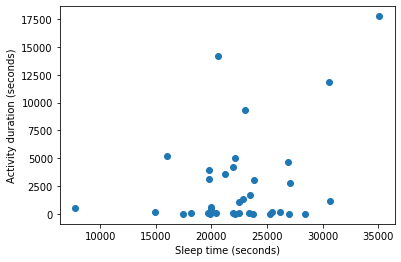

Covariance [[23862268.91428571  7672326.94537143]
 [ 7672326.94537143 18270063.34706336]]

Pearsons correlation: 0.36745250042465266

Spearmans correlation: 0.09458770740426942



In [7]:
# generate related variables
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot


# summarize
print('activity_duration: mean=%.3f stdv=%.3f' % (mean(activity_duration), std(activity_duration)))
print('bedtime_end_delta: mean=%.3f stdv=%.3f' % (mean(bedtime_end_delta), std(bedtime_end_delta)))
# plot

pyplot.scatter(bedtime_end_delta, activity_duration)
# pyplot.ylim([10, 6000])
pyplot.ylabel("Activity duration (seconds)")
pyplot.xlabel("Sleep time (seconds)")
pyplot.show()


# todo (visualization to explain suggestion):
# plot across frequency & duration 
# standardize to a scale

# covariance
from numpy import cov

covariance = cov(bedtime_end_delta, activity_duration)
print(f"Covariance {covariance}\n")


# pearson correlation - strength of the linear relationship between two data samples.
from scipy.stats import pearsonr
# calculate Pearsons correlation
corr, _ = pearsonr(bedtime_end_delta, activity_duration)
print(f"Pearsons correlation: {corr}\n")

# spearmans correlation - 
from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(bedtime_end_delta, activity_duration)
print(f'Spearmans correlation: {corr}\n')

<AxesSubplot:>

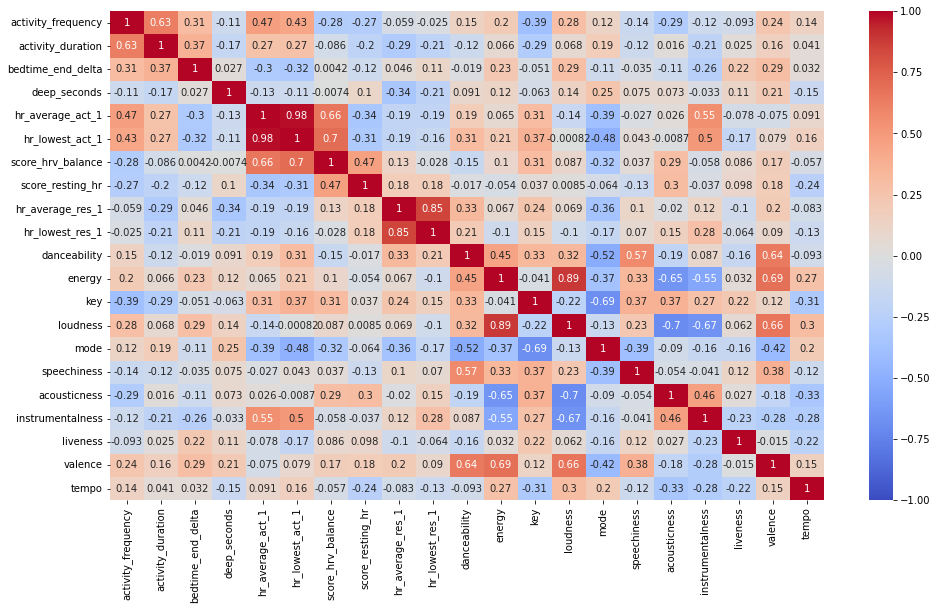

In [8]:
# do correlation on the whole pandas dataset
combined_pearson_correlation = combined_dataset_2.corr(method="pearson")

plt.figure(figsize=(16,9))
 
sns.heatmap(combined_pearson_correlation, cmap="coolwarm", vmin= -1, vmax=1, annot = True)

<AxesSubplot:>

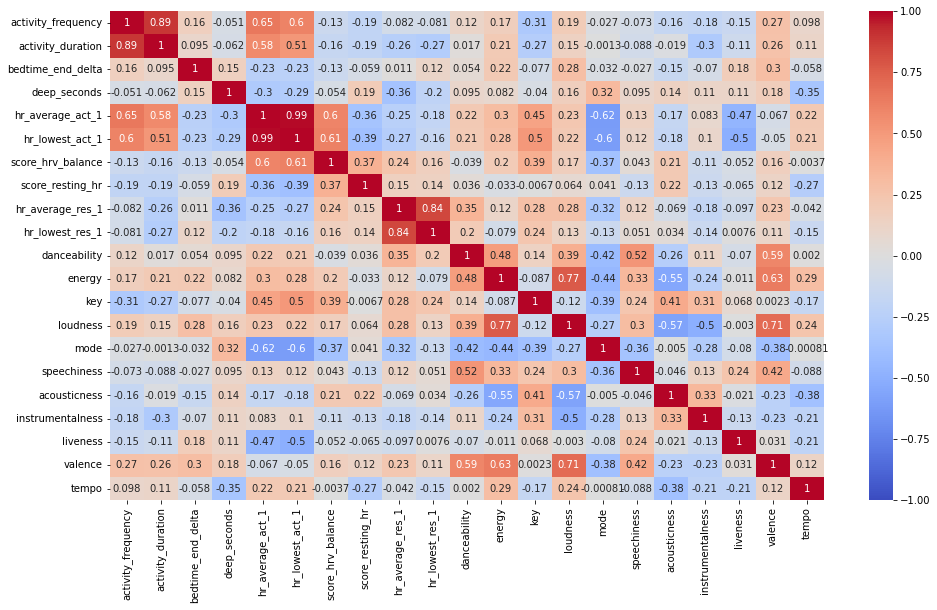

In [9]:
# do correlation on the whole pandas dataset
combined_spearman_correlation = combined_dataset_2.corr(method="spearman")

plt.figure(figsize=(16,9))
 
sns.heatmap(combined_spearman_correlation, cmap="coolwarm", vmin= -1, vmax=1, annot = True)

In [10]:
# next step - have data for a longer period of time... include until November


# add more data sources to correlation (twitter, google_calendar, spotify)

"""
for twitter
- sentiment
- summary_day
"""

'\nfor twitter\n- sentiment\n- summary_day\n'